In [ ]:
# necessary import(s)
# standard library
import os
import requests
import copy
import time

import functools
from zipfile import ZipFile
from pathlib import Path
from typing import Tuple, Callable, Union, Any

# third party
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# third party library installation if needed
try:
    from torchinfo import summary
    from tqdm.autonotebook import tqdm
    from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
except:
    # installing torchinfo and then importing
    print("[INFO] Installing torchinfo for network architecture explanation.")
    !pip install torchinfo
    from torchinfo import summary

    # for readability
    print()

    # installing tqdm and then importing
    print("[INFO] Installing tqdm for progress bar.")
    !pip install tqdm
    from tqdm.autonotebook import tqdm

    # for readability
    print()

    # installing torchmetrics and importing MulticlassAccuracy and MulticlassF1Score
    print("[INFO] Installing torchmetrics for computing metrics for training/eval runs.")
    !pip install torchmetrics
    from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

[INFO] Installing torchinfo for network architecture explanation.

[INFO] Installing tqdm for progress bar.


<ipython-input-1-e33ae79972ff>:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



[INFO] Installing torchmetrics for computing metrics for training/eval runs.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 11.6 MB/s eta 0:00:00


In [ ]:

# Define the path where the 'currency.zip' file was uploaded
currency_zip_path = "/content/currency.zip"
currency_output_dir = "/content/currency_data"  # Directory to extract to

# Create the directory if it doesn't exist
os.makedirs(currency_output_dir, exist_ok=True)
print(f"Extracted files from: {currency_zip_path}")
# Extract the zip file
with ZipFile(currency_zip_path, 'r') as zip_ref:
    zip_ref.extractall(currency_output_dir)

print(f"Extracted files to: {currency_output_dir}")


Extracted files from: /content/currency.zip
Extracted files to: /content/currency_data


In [ ]:

# Define the path where the 'currency.zip' file was uploaded
currency_zip_path = "/content/Damage.zip"
currency_output_dir = "/content/Damage_data"  # Directory to extract to

# Create the directory if it doesn't exist
os.makedirs(currency_output_dir, exist_ok=True)
print(f"Extracted files from: {currency_zip_path}")
# Extract the zip file
with ZipFile(currency_zip_path, 'r') as zip_ref:
    zip_ref.extractall(currency_output_dir)

print(f"Extracted files to: {currency_output_dir}")

Extracted files from: /content/Damage.zip
Extracted files to: /content/Damage_data


In [ ]:

# Define the path where the 'currency.zip' file was uploaded
currency_zip_path = "Undamage.zip"
currency_output_dir = "Undamage_data"  # Directory to extract to

# Create the directory if it doesn't exist


os.makedirs(currency_output_dir, exist_ok=True)
print(f"Extracted files from: {currency_zip_path}")
# Extract the zip file
with ZipFile(currency_zip_path, 'r') as zip_ref:
    zip_ref.extractall(currency_output_dir)

print(f"Extracted files to: {currency_output_dir}")
CURRENCY_DATASET = "currency_data/currency"

Extracted files from: Undamage.zip


FileNotFoundError: [Errno 2] No such file or directory: 'Undamage.zip'

In [ ]:
CURRENCY_DATASET = "/content/currency_data/currency"


In [ ]:
import os
import shutil
import random


# Define source directory (where all the images are currently stored)
source_dir = '/content/Damage_data/Damage'

# Define target directories for training and validation splits
train_dir = '/content/Damage_data/Damage/train'
val_dir = '/content/Damage_data/Damage/val'

# Create the train and val directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Define the split ratio
train_split = 0.8  # 80% training, 20% validation

# List of class directories (10, 20, 50, 100)
classes = ['10', '20', '50', '100']

# Iterate over each class and split the images
for class_name in classes:
    class_path = os.path.join(source_dir, class_name)

    # Ensure that the train and val class directories are created
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Get the list of all images in the current class directory
    images = os.listdir(class_path)

    # Sort images to ensure the split is not random (sequential split)
    random.shuffle(images)

    # Determine the split point (sequential split)
    split_point = int(train_split * len(images))

    # Split the images into training and validation sets (without shuffling)
    train_images = images[:split_point]
    val_images = images[split_point:]

    # Move training images to the train directory
    for img in train_images:
        img_src = os.path.join(class_path, img)
        img_dst = os.path.join(train_class_dir, img)
        shutil.move(img_src, img_dst)

    # Move validation images to the val directory
    for img in val_images:
        img_src = os.path.join(class_path, img)
        img_dst = os.path.join(val_class_dir, img)
        shutil.move(img_src, img_dst)

print("Dataset successfully split into train and val sets (sequential).")


Dataset successfully split into train and val sets (sequential).


In [ ]:
# creating function for maintaining reproducibility

def manual_seed(random_seed: int = 42) -> None:
    '''
    For maintaining reproducibility of a notebook cell.
    '''
    # for non-cuda
    torch.manual_seed(random_seed)
    # in case cuda exists
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

# creating device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# clearing cache if using GPU
if str(device) == "cuda":
    torch.cuda.empty_cache()

In [ ]:
# selecting hyperparameters

BATCH_SIZE = 32
LEARNING_RATE = 2e-4
EPOCHS = 15
HIDDEN_LAYER_1 = 256
HIDDEN_LAYER_2 = 128

In [ ]:
# an overview of how the multi-weight support API works: need torch v1.12+ and torchvision 0.14+

resnet_34_weights = torchvision.models.ResNet34_Weights.DEFAULT     # DEFAULT will give you the best possible weights

# we can look at the transforms used for training the given weights for this network architecture
resnet_34_default_transforms = resnet_34_weights.transforms()

# checking transforms
print(resnet_34_default_transforms)

# creating ResNet-34 architecture using the weights specified above
model = torchvision.models.resnet34(weights = resnet_34_weights)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 59.6MB/s]


In [ ]:
# using torchinfo to inspect the network
summary(model,
        input_size=(1,3,224,224),
        col_names=("input_size",
                   "output_size",
                   "num_params",
                   "kernel_size",
                   "mult_adds",
                   "trainable"),
        col_width=20,
        row_settings=("var_names",))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   --                   --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                [7, 7]               118,013,952          True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  --                   128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --                   --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   3                    --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --        

In [ ]:
# we can either use these transforms or compose transforms manually (doing train_transforms manually because we need data augmentation)

# 1. training transform: if TrivialAugmentWide is not available for your torchvision version use other data augmentation techniques (https://pytorch.org/vision/stable/transforms.html#v1-api-reference)
train_transforms = transforms.Compose([transforms.Resize(size=(256,256),
                                                         interpolation=transforms.InterpolationMode.BILINEAR),
                                       transforms.TrivialAugmentWide(interpolation = transforms.InterpolationMode.BILINEAR),
                                       transforms.CenterCrop(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# 2. using resnet_34_default_transforms for val/test sets

In [ ]:
# creating torchvision.ImageFolder datasets

# 1. training dataset
train_dataset = torchvision.datasets.ImageFolder(root = str(source_dir / Path('train')),
                                        transform=train_transforms)

# 2. validation dataset
val_dataset = torchvision.datasets.ImageFolder(root = str(source_dir / Path('val')),
                                      transform=resnet_34_default_transforms)

# extracting number of classes and class_to_idx mapping
CLASSES = train_dataset.classes
NUM_CLASSES = len(CLASSES)

CLASS_TO_IDX = train_dataset.class_to_idx

In [ ]:
# creating torchvision.ImageFolder datasets
#for undamged
# 1. training dataset
train_dataset = torchvision.datasets.ImageFolder(root = str(CURRENCY_DATASET / Path('train')),
                                        transform=train_transforms)

# 2. validation dataset
val_dataset = torchvision.datasets.ImageFolder(root = str(CURRENCY_DATASET / Path('test')),
                                      transform=resnet_34_default_transforms)

# extracting number of classes and class_to_idx mapping
CLASSES = train_dataset.classes
NUM_CLASSES = len(CLASSES)

CLASS_TO_IDX = train_dataset.class_to_idx

In [ ]:
# creating dataloaders

# 1. training set dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=os.cpu_count() if str(device) == "cuda" else 0,      # if you have GPU it makes sense to spin up multiple worker processes to fetch data batches, num_workers=<cpu cores> is a good rule of thumb (https://stackoverflow.com/a/54002191)
                                           pin_memory=True if str(device) == "cuda" else False)             # if you have GPU it almost always makes sense to have 'pin_memory = True', as this makes the data transfer to GPU more efficient (https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/2)

# 2. validation set dataloader
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                         pin_memory=True if str(device) == "cuda" else False)

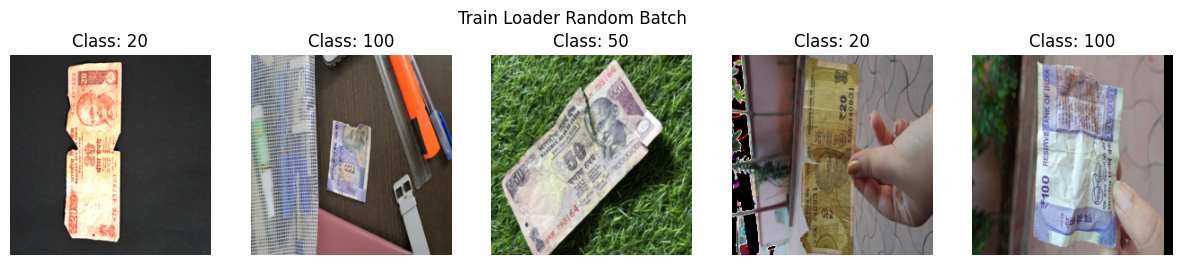

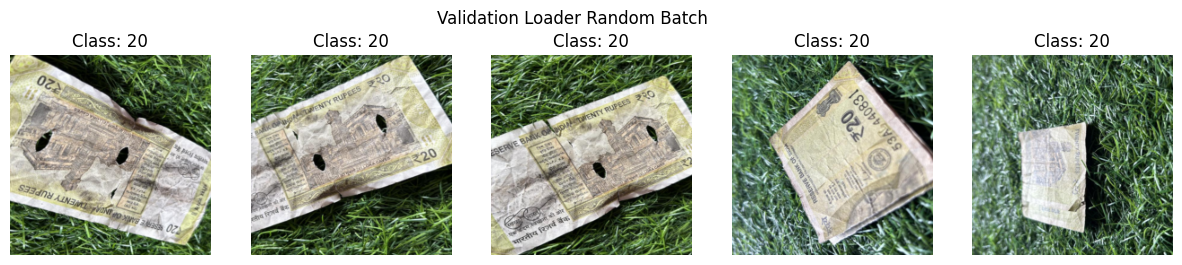

In [ ]:
def denormalize_and_clip(img, mean, std):
    img = img.numpy(force=True) if isinstance(img, torch.Tensor) else img
    img = np.transpose(img, (1, 2, 0))

    # Denormalize and clip values to stay in the valid range [0, 1]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

def imshow(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Remove ticks and axes
    plt.show()

def visualize_random_batch(data_loader, loader_type, mean, std):
    # Get a random batch index
    batch_index = np.random.randint(len(data_loader))

    # Get the random batch from the data loader
    for i, (images, labels) in enumerate(data_loader):
        if i == batch_index:
            break

    # Define the classes (assuming your dataset has a 'classes' attribute)
    classes = data_loader.dataset.classes

    # Display images from the random batch in a grid
    num_images_to_show = min(5, len(images))  # Display at most 5 images
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

    for i in range(num_images_to_show):
        image = images[i]
        label = labels[i].item()
        class_name = classes[label]

        # Show the image
        image = denormalize_and_clip(image, mean, std)  # Apply denormalization
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')  # Remove ticks and axes

    plt.suptitle(f'{loader_type} Random Batch')
    plt.show()

# Example usage with your dataloaders
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

visualize_random_batch(train_loader, 'Train Loader', mean, std)  # Visualization of a random batch from the training set
visualize_random_batch(val_loader, 'Validation Loader', mean, std)  # Visualization of a random batch from the validation set

In [ ]:
# swapping out the resnet classifier head

# using the function 'manual_seed()' created above to lock reproducibility of this cell
manual_seed()

# freezing out the complete network first
for param in model.parameters():
    param.requires_grad = False


# now swapping out the MLP classifier head
model.fc = nn.Sequential(nn.Linear(512, HIDDEN_LAYER_1),
                         nn.ReLU(),
                         nn.Dropout(p=0.2),
                         nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
                         nn.ReLU(),
                         nn.Dropout(p=0.2),
                         nn.Linear(HIDDEN_LAYER_2, len(train_dataset.classes)))

In [ ]:
# checking details after freezing the convolution backbone and swapping out the classifier head
summary(model,
        input_size=(1,3,224,224),
        col_names=("input_size",
                   "output_size",
                   "num_params",
                   "kernel_size",
                   "mult_adds",
                   "trainable"),
        col_width=20,
        row_settings=("var_names",))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 4]               --                   --                   --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              [7, 7]               118,013,952          False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                --                   128                  False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --                   --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   3                    --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --   

In [ ]:
# creating a single step of training
def training_step(model: nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  criterion: nn.Module,
                  training_accuracy: MulticlassAccuracy,
                  training_f1: MulticlassF1Score,
                  epoch_num: int,
                  device: torch.device = device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Function for a single step of training.

    Args:
        model: The model/network to train
        train_dataloader: The dataloader for training set
        optimizer: The optimization algorithm to use
        criterion: The error function for setting up the optimization problem
        training_accuracy: Instance of MulticlassAccuracy class from torchmetrics
        training_f1: Instance of MulticlassF1Score class from torchmetrics
        epoch_num: The current epoch number
        device: The device being used for model/network training [Default: device]

    Returns:
        Tuple of training loss, training accuracy and training f1 score
    '''

    # setting the model to train mode
    model.train()

    # placeholder for calculating loss epoch wise
    epoch_loss = 0

    # using tqdm for progress bar
    with tqdm(enumerate(train_dataloader, start=1), total=len(train_dataloader), unit=" train-batch") as tepoch:
        # iterating over the data batches
        for batch_idx, (features, labels) in tepoch:
            # setting description (prefix) for tqdm progress bar
            tepoch.set_description(f"Epoch: {epoch_num+1} | Phase - Training")

            # moving the batches to device
            features, labels = features.to(device), labels.to(device).type(torch.long)      # typecasting labels (if using CE Loss)

            # doing forward propagation
            logits = model(features)
            # calculating loss
            loss = criterion(logits, labels)
            # zeroing out accumulated gradients from the previous iteration
            optimizer.zero_grad()
            # doing backpropagation: computing partial derivatives
            loss.backward()
            # taking an optimization step using the gradients computed above
            optimizer.step()

            # calculating average loss and Accuracy/F1-Score per batch (removing this part from computation graph)
            with torch.inference_mode():        # use torch.no_grad() if torch.inference_mode() is not available in PyTorch version
                avg_loss_sample = loss/len(labels)
                batch_acc = training_accuracy.forward(logits, labels)
                batch_f1 = training_f1.forward(logits, labels)

            # accumulating in epoch loss
            epoch_loss += avg_loss_sample

            # setting postfix for progress bar
            tepoch.set_postfix(batch_f1_score=batch_f1.item(), batch_accuracy=f"{batch_acc.item()*100:.2f}%", loss_per_sample=avg_loss_sample.item())

    # averaging loss over batches
    epoch_loss /= len(train_dataloader)

    # for readability
    print()

    # printing epoch statistics
    print(f"[INFO] Epoch: {epoch_num+1} | loss: {epoch_loss.item():.3f} | training acc: {training_accuracy.compute().item()*100:.2f}% | training f1-score: {training_f1.compute().item():.2f}")

    # returning loss, acc and f1
    return epoch_loss, training_accuracy.compute(), training_f1.compute()

In [ ]:
# creating a single step of testing


def testing_step(model: nn.Module,
                 test_dataloader: torch.utils.data.DataLoader,
                 criterion: nn.Module,
                 test_accuracy: MulticlassAccuracy,
                 test_f1: MulticlassF1Score,
                 epoch_num: int = -1,
                 device: torch.device = device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Function for a single step of testing.

    Args:
        model: The model/network to train
        test_dataloader: The dataloader for test set
        criterion: The error function for quantifying how wrong predictions are
        test_accuracy: Instance of MulticlassAccuracy class from torchmetrics
        test_f1: Instance of MulticlassF1Score class from torchmetrics
        epoch_num: The current epoch number [Default: -1]
        device: The device being used for model/network testing [Default: device]

    Returns:
        Tuple of test loss, test accuracy and test f1 score
    '''

    # setting the model to eval mode
    model.eval()

    # placeholder for calculating loss epoch wise
    epoch_loss = 0

    # using tqdm for progress bar
    with tqdm(enumerate(test_dataloader, start=1), total=len(test_dataloader), unit=" test-batch") as tepoch:
        # iterating over the data batches
        for batch_idx, (features, labels) in tepoch:
            # setting description (prefix) for tqdm progress bar
            tepoch.set_description(f"Epoch: {epoch_num+1} | Phase - Validation/Test")

            # moving the batches to device
            features, labels = features.to(device), labels.to(device).type(torch.long)      # typecasting labels (if using CE Loss)

            # doing forward poss + loss computation, calculating average loss and Accuracy/F1-Score per batch (removing this part from computation graph)
            with torch.inference_mode():        # use torch.no_grad() if torch.inference_mode() is not available in PyTorch version
                # doing forward propagation
                logits = model(features)
                # calculating loss
                loss = criterion(logits, labels)
                # calculating per sample loss in a batch
                avg_loss_sample = loss/len(labels)
                # calculating accuracy for the batch
                batch_acc = test_accuracy.forward(logits, labels)
                # calculating f1-score for the batch
                batch_f1 = test_f1.forward(logits, labels)

            # accumulating in epoch loss
            epoch_loss += avg_loss_sample

            # setting postfix for progress bar
            tepoch.set_postfix(batch_f1_score=batch_f1.item(), batch_accuracy=f"{batch_acc.item()*100:.2f}%", loss_per_sample=avg_loss_sample.item())

    # averaging loss over batches
    epoch_loss /= len(test_dataloader)

    # for readability
    print()

    # printing epoch statistics
    print(f"[INFO] Epoch: {epoch_num+1} | loss: {epoch_loss.item():.3f} | val/test acc: {test_accuracy.compute().item()*100:.2f}% | val/test f1-score: {test_f1.compute().item():.2f}")

    # for readability
    print()

    # returning loss, acc and f1
    return epoch_loss, test_accuracy.compute(), test_f1.compute()


In [ ]:
# decorating function for training function below

def timing_function(func: Callable[..., Any]) -> Callable[..., Any]:
    '''
    Decorating function for determining the time taken for execution of a function.

    Args:
        func: Function whose execution time has to be determined

    Returns:
        wrapper function around the function whose execution time we have to determine
    '''

    # using wraps to preserve function signature
    @functools.wraps(func)
    def wrapper(*args, **kwargs) -> Any:
        '''
        The wrapper function wrapping the function that was input to timing_function.

        Args:
            *args: Variable length positional argument(s)
            *kwargs: Variable length keyword argument(s)

        Returns:
            Any output received from the 'func' function
        '''

        # computing time taken for execution of function (training pipeline etc.)
        start_time = time.perf_counter()
        func_out = func(*args, **kwargs)
        end_time = time.perf_counter()

        # for readability
        print()
        print()

        # printing time statistics
        print(f"[INFO] Time taken -> {(end_time-start_time)//60}m and {(end_time-start_time)%60:.2f}s")

        # return statement for wrapper
        return func_out
    # returning wrapper
    return wrapper

In [ ]:
# training pipeline: combining the two functions training_step and testing_step

@timing_function
def training(model: nn.Module,
             train_dataloader: torch.utils.data.DataLoader,
             test_dataloader: torch.utils.data.DataLoader,
             optimizer: torch.optim.Optimizer,
             criterion: nn.Module,
             training_accuracy: MulticlassAccuracy,
             training_f1: MulticlassF1Score,
             test_accuracy: MulticlassAccuracy,
             test_f1: MulticlassF1Score,
             epochs: int = 5,
             device: torch.device = device) -> Tuple[dict, dict]:
             '''
             Function defining the training pipeline.

             Args:
                 model: The model/network to train
                 train_dataloader: The dataloader for training set
                 test_dataloader: The dataloader for test set
                 optimizer: The optimization algorithm to use
                 criterion: The error function for setting up the optimization problem
                 training_accuracy: Instance of MulticlassAccuracy class from torchmetrics (for training)
                 training_f1: Instance of MulticlassF1Score class from torchmetrics (for training)
                 test_accuracy: Instance of MulticlassAccuracy class from torchmetrics (for test)
                 test_f1: Instance of MulticlassF1Score class from torchmetrics (for test)
                 epochs: The number of epochs to train the model for [Default: 5]
                 device: The device being used for model/network training + eval [Default: device]

             Returns:
                 None
             '''

             # moving model to device
             model.to(device)

             # moving torchmetrics metric objects to device
             training_accuracy.to(device)
             training_f1.to(device)
             test_accuracy.to(device)
             test_f1.to(device)

             # lists for tracking loss and metrics
             train_loss = []
             train_acc = []
             train_f1 = []
             val_loss = []
             val_acc = []
             val_f1 = []

             # will be used for keeping track of best performing model
             best_loss = float("inf")

             # training model for given number of epochs
             for epoch_iter in range(epochs):
                # single step of training
                train_epoch_loss, train_epoch_acc, train_epoch_f1 = training_step(model,
                                                                                  train_dataloader,
                                                                                  optimizer,
                                                                                  criterion,
                                                                                  training_accuracy,
                                                                                  training_f1,
                                                                                  epoch_iter,
                                                                                  device)
                # appending to respective lists (train)
                train_loss.append(train_epoch_loss)
                train_acc.append(train_epoch_acc)
                train_f1.append(train_epoch_f1)

                # for readability
                print()

                # single step of validation
                val_epoch_loss, val_epoch_acc, val_epoch_f1 = testing_step(model,
                                                                           test_dataloader,
                                                                           criterion,
                                                                           test_accuracy,
                                                                           test_f1,
                                                                           epoch_iter,
                                                                           device)
                # appending to respective lists (test)
                val_loss.append(val_epoch_loss)
                val_acc.append(val_epoch_acc)
                val_f1.append(val_epoch_f1)

                # for readability
                print()

                # checking if loss has improved
                if best_loss > val_epoch_loss:
                    best_model = copy.deepcopy(model.state_dict())       # taking a deepcopy of model.state_dict()
                    best_loss = val_epoch_loss
                    best_epoch = epoch_iter

             # using list comprehension for loss, acc and f1 lists
             train_loss = [tensor.item() for tensor in train_loss]
             train_acc = [tensor.item() for tensor in train_acc]
             train_f1 = [tensor.item() for tensor in train_f1]
             val_loss = [tensor.item() for tensor in val_loss]
             val_acc = [tensor.item() for tensor in val_acc]
             val_f1 = [tensor.item() for tensor in val_f1]

             # creating training statistics dictionary
             training_statistics = {"training_loss": train_loss,
                                    "training_accuracy": train_acc,
                                    "training_f1": train_f1,
                                    "validation_loss": val_loss,
                                    "validation_accuracy": val_acc,
                                    "validation_f1": val_f1,
                                    "best_epoch": best_epoch+1,
                                    "loss_on_best_epoch": best_loss.item(),
                                    "device_used": device}

             # for readability
             print()
             print()

             # printing training statistics
             print(f"Best epoch: {training_statistics['best_epoch']} | Training acc on best epoch: {training_statistics['training_accuracy'][training_statistics['best_epoch']-1]*100:.2f}% | Validation acc on best epoch: {training_statistics['validation_accuracy'][training_statistics['best_epoch']-1]*100:.2f}%")

             # returning best performing model and statistics dictionary
             return best_model, training_statistics


In [ ]:
# for saving and loading model

# saving model
def save_model(model: nn.Module,
               model_name: str) -> str:
    '''
    Function for saving state_dict of model.

    Args:
        model: model (nn.Module) whose state_dict you have to save
        model_name: The name to use for saving the state_dict

    Returns:
        The path to saved state_dict (str)
    '''

    # model save location
    SAVE_PATH = f"./{model_name}.pt"

    # saving model and printing message
    torch.save(model.state_dict(), SAVE_PATH)
    print(f"[INFO] {model_name} saved to {SAVE_PATH}")

    # returning path of saved model
    return SAVE_PATH

# saving general checkpoint
def save_checkpoint(optimizer: torch.optim.Optimizer,
                    criterion: nn.Module,
                    epoch: int,
                    device_trained_on: torch.device,
                    hidden_layers: tuple,
                    output_layer: int,
                    classes: list,
                    class_to_idx: dict,
                    checkpoint_name: str = "checkpoint") -> str:


    # checkpoint save location
    SAVE_PATH = f"./{checkpoint_name}.pth"

    # saving the checkpoint
    torch.save({"optimizer": optimizer.state_dict(),
                "criterion": criterion,
                "epoch": epoch,
                "device_trained_on": device_trained_on,
                "hidden_layers": hidden_layers,
                "output_layer": output_layer,
                "classes": classes,
                "class_to_idx": class_to_idx}, SAVE_PATH)

    # printing save confirmation
    print(f"[INFO] The general checkpoint has been saved to: {SAVE_PATH}")

    # returning the saved checkpoint path
    return SAVE_PATH

# loading model
def load_model(model_save_path: str,
               hidden_layers: tuple,
               output_layer: int,
               device_trained_on: torch.device,
               device: torch.device) -> nn.Module:
    '''
    Function for loading state_dict() of the saved model and inserting that into a newly defined architecture (must be same as original model arch).

    Args:
        model_save_path: Save path to the state_dict() of model
        hidden_layers: The specifications of the two hidden layers
        output_layer: The specification of the output layer
        device_trained_on: The device on which the model was trained on originally
        device: The device on which the newly defined model should be moved to

    Returns:
        The model with loaded state_dict()
    '''

    # building resnet
    model = torchvision.models.resnet34(weights = None)

    # swapping classifier head using hidden layers
    model.fc = nn.Sequential(nn.Linear(512, hidden_layers[0]),
                             nn.ReLU(),
                             nn.Dropout(p=0.2),
                             nn.Linear(hidden_layers[0], hidden_layers[1]),
                             nn.ReLU(),
                             nn.Dropout(p=0.2),
                             nn.Linear(hidden_layers[1], output_layer))

    # loading model state_dict
    if str(device_trained_on) in ("cuda", "cuda:0"):
        # saved on GPU, loading on CPU case
        if str(device) == "cpu":
            model.load_state_dict(torch.load(model_save_path, map_location=device))
        # saved on GPU, loading on GPU case
        elif str(device) in ("cuda", "cuda:0"):
            model.load_state_dict(torch.load(model_save_path))
    else:
        # saved on CPU, loading on CPU case
        if str(device) == "cpu":
            model.load_state_dict(torch.load(model_save_path))
        # saved on CPU, loading on GPU case
        elif str(device) in ("cuda", "cuda:0"):
            model.load_state_dict(torch.load(model_save_path, map_location="cuda:0"))

    # moving model to device and switching to eval mode
    model.to(device);
    model.eval();

    # returning model
    return model

# loading model
def load_checkpoint(checkpoint_save_path: str) -> dict:
    '''
    Function for loading checkpoint dictionary from given path of the saved checkpoint.

    Args:
        checkpoint_save_path: Path to the general checkpoint .pth file

    Returns:
        The checkpoint dictionary (dict)
    '''

    # returning checkpoint dictionary
    CHECKPOINT_DICT = torch.load(checkpoint_save_path)
    return CHECKPOINT_DICT


In [ ]:
# creating criterion, optimizer and metrics

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters(),        # change this to torch.optim.Adam
                             lr = LEARNING_RATE)

# creating metrics to be used in training pipeline (for training and validation phase)
training_acc = MulticlassAccuracy(num_classes = NUM_CLASSES)
training_f1 = MulticlassF1Score(num_classes = NUM_CLASSES)
val_acc = MulticlassAccuracy(num_classes = NUM_CLASSES)
val_f1 = MulticlassF1Score(num_classes = NUM_CLASSES)

In [ ]:
# using manual_seed for reproducbility
manual_seed()


# starting training
resnet_state_dict, training_stats = training(model,
                                             train_dataloader = train_loader,
                                             test_dataloader = val_loader,
                                             optimizer = optimizer,
                                             criterion = criterion,
                                             training_accuracy = training_acc,
                                             training_f1 = training_f1,
                                             test_accuracy = val_acc,
                                             test_f1 = val_f1,
                                             epochs=EPOCHS)

  0%|          | 0/117 [00:00<?, ? train-batch/s]


[INFO] Epoch: 1 | loss: 0.040 | training acc: 38.15% | training f1-score: 0.36



  0%|          | 0/30 [00:00<?, ? test-batch/s]


[INFO] Epoch: 1 | loss: 0.037 | val/test acc: 46.45% | val/test f1-score: 0.42




  0%|          | 0/117 [00:00<?, ? train-batch/s]


[INFO] Epoch: 2 | loss: 0.033 | training acc: 47.20% | training f1-score: 0.47



  0%|          | 0/30 [00:00<?, ? test-batch/s]


[INFO] Epoch: 2 | loss: 0.027 | val/test acc: 61.15% | val/test f1-score: 0.62




  0%|          | 0/117 [00:00<?, ? train-batch/s]


[INFO] Epoch: 3 | loss: 0.028 | training acc: 52.72% | training f1-score: 0.53



  0%|          | 0/30 [00:00<?, ? test-batch/s]


[INFO] Epoch: 3 | loss: 0.023 | val/test acc: 66.77% | val/test f1-score: 0.68




  0%|          | 0/117 [00:00<?, ? train-batch/s]


[INFO] Epoch: 4 | loss: 0.025 | training acc: 56.89% | training f1-score: 0.57



  0%|          | 0/30 [00:00<?, ? test-batch/s]

In [ ]:
# function to plot curves

def plot_curves(stats):
    # Extract data from the dictionary
    training_loss = stats['training_loss']
    training_accuracy = stats['training_accuracy']
    training_f1 = stats['training_f1']

    validation_loss = stats['validation_loss']
    validation_accuracy = stats['validation_accuracy']
    validation_f1 = stats['validation_f1']

    best_epoch = stats['best_epoch']
    loss_on_best_epoch = stats['loss_on_best_epoch']

    epochs = range(1, len(training_loss) + 1)

    # Plotting loss curve
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.scatter(best_epoch, loss_on_best_epoch, color='darkred', marker='o', label='Best Epoch')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    # Plotting accuracy curve
    plt.subplot(1, 3, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    # Plotting F1-score curve
    plt.subplot(1, 3, 3)
    plt.plot(epochs, training_f1, label='Training F1-score')
    plt.plot(epochs, validation_f1, label='Validation F1-score')
    plt.title('F1-score Curves')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.xticks(epochs)  # Ensure x-axis ticks are integers
    plt.legend()

    plt.tight_layout()
    plt.show()

# displaying curves
plot_curves(training_stats)

In [ ]:
# saving model and checkpoint
MODEL_SAVE_PATH = save_model(model, "resnet_34")
CHKPT_SAVE_PATH = save_checkpoint(optimizer,
                                  criterion,
                                  epoch = training_stats["best_epoch"]-1,
                                  device_trained_on = device,
                                  hidden_layers = (HIDDEN_LAYER_1, HIDDEN_LAYER_2),
                                  output_layer = NUM_CLASSES,
                                  classes = CLASSES,
                                  class_to_idx = CLASS_TO_IDX,
                                  checkpoint_name = "checkpoint")

# loading model and checkpoint
CHKPT_DICT = load_checkpoint(CHKPT_SAVE_PATH)
new_model = load_model(MODEL_SAVE_PATH,
                       hidden_layers = CHKPT_DICT["hidden_layers"],
                       output_layer = CHKPT_DICT["output_layer"],
                       device_trained_on = CHKPT_DICT["device_trained_on"],
                       device = torch.device("cpu"))

In [ ]:
# function to predict on a give image sample and draw a bargraph

@timing_function
def predict_and_plot_topk(model: nn.Module,
                          img_transform: transforms.Compose,
                          class_list: list,
                          image_path: str,
                          device: torch.device,
                          topk: int = 5):

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = img_transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    # Moving model to device and switching to eval mode
    model.to(device)
    model.eval()

    # Make predictions
    with torch.inference_mode():
        output = model(input_batch)

    # Convert the output to probabilities using softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get the top-k class indices and probabilities
    topk_probs, topk_indices = torch.topk(probabilities, topk)
    topk_probs_np = topk_probs.numpy(force=True)
    topk_indices_np = topk_indices.numpy(force=True)

    # Convert tensor to numpy array for plotting
    probs_np = probabilities.numpy(force=True)

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    # Plot the top-k classes
    plt.subplot(2, 1, 2)
    plt.barh([class_list[i] for i in topk_indices_np], topk_probs_np, color='blue')
    plt.xlabel('Predicted Probability')
    plt.title(f'Top-{topk} Predicted Classes')

    plt.tight_layout()
    plt.show()

# downloading a sample image
#wget https://i.ytimg.com/vi/tXjHb5QmDV0/maxresdefault.jpg -O /content/Damage_data/Damage/50 Rupees/50_new_101.jpg     # provide link to any .jpg image here

# Example usage
# Assuming you have a PyTorch model 'new_model', a list of class names extracted using dataset_name.classes, and an image file path
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "/content/Damage_data/Damage/val/10/10_new_52.jpg",
                      device,
                      topk=1)


In [ ]:
# Example usage
# Assuming you have a PyTorch model 'new_model', a list of class names extracted using dataset_name.classes, and an image file path
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "/content/Damage_data/Damage/val/20/20_old_278.jpg",
                      device,
                      topk=1)

In [ ]:
# Example usage
# Assuming you have a PyTorch model 'new_model', a list of class names extracted using dataset_name.classes, and an image file path
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "/content/Damage_data/Damage/val/50/50_old_41.jpg",
                      device,
                      topk=1)

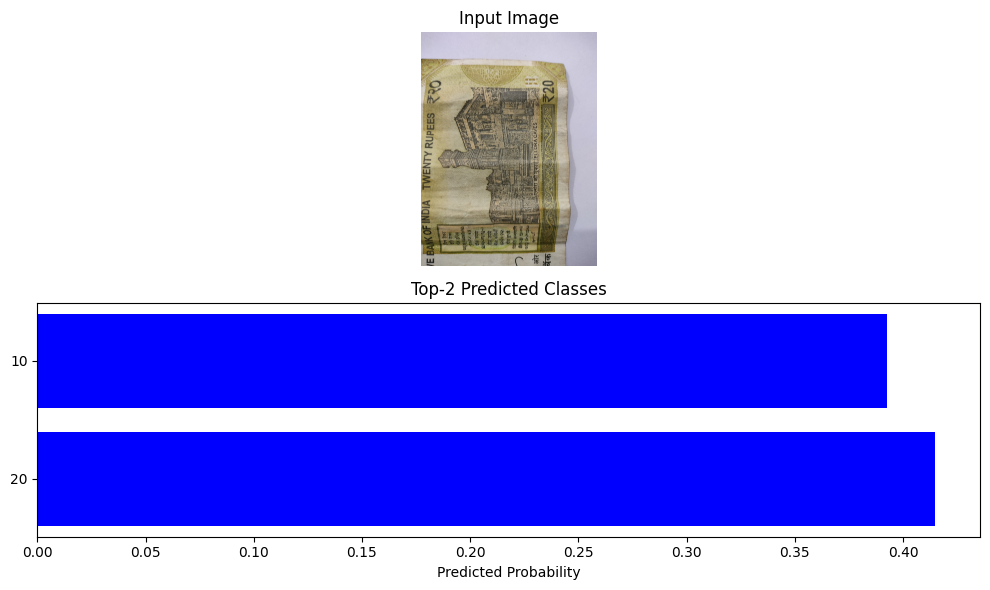



[INFO] Time taken -> 0.0m and 3.32s


In [ ]:
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "/content/currency_data/currency/test/20/IMG20220929005140.jpg",
                      device,
                      topk=2)



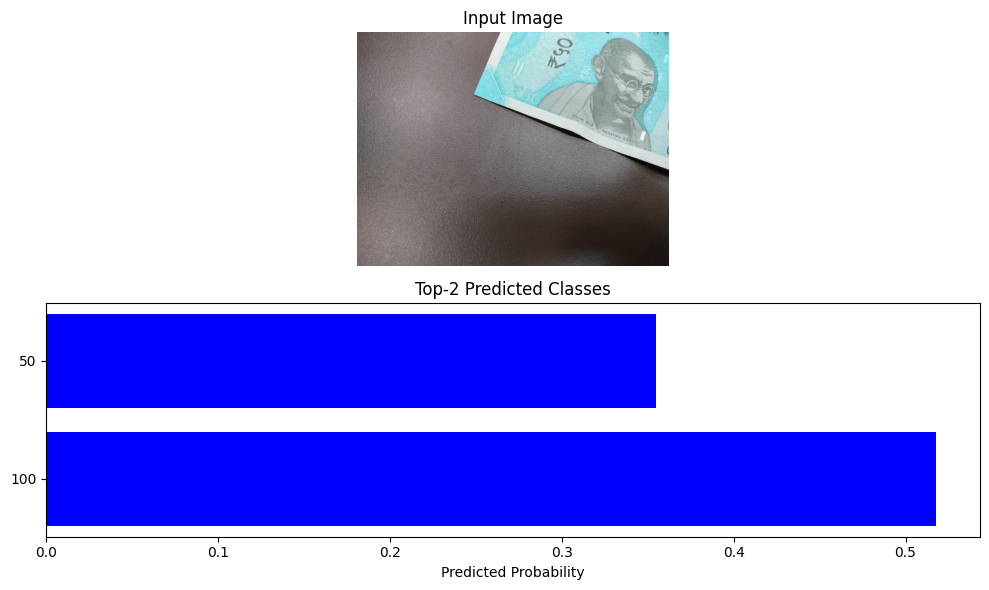



[INFO] Time taken -> 0.0m and 2.62s


In [ ]:
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "/content/currency_data/currency/test/50/IMG20220927125331.jpg",
                      device,
                      topk=2)

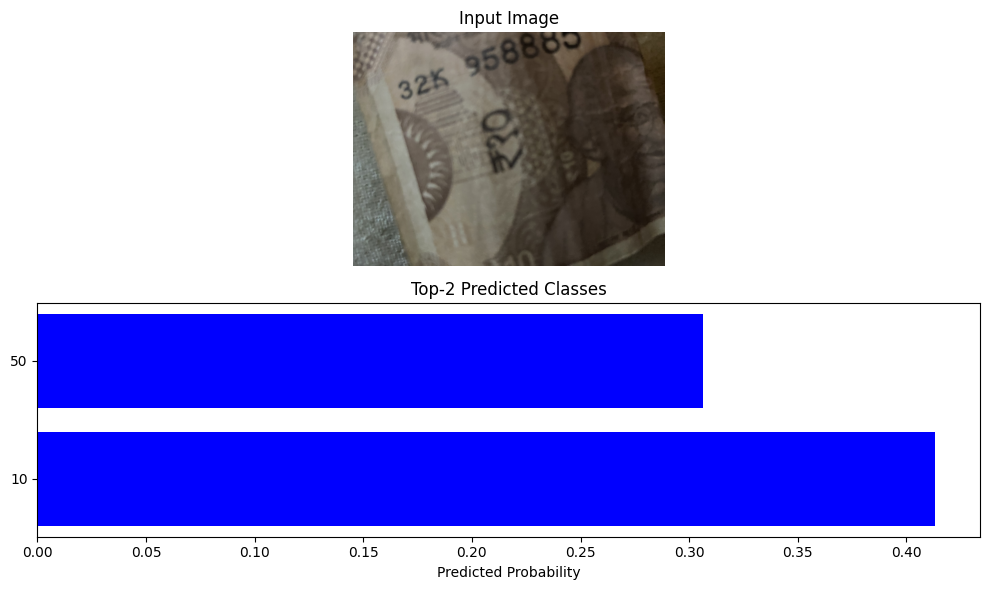



[INFO] Time taken -> 0.0m and 4.63s


In [ ]:
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "/content/currency_data/currency/test/10/IMG_1867.jpg",
                      device,
                      topk=2)